In [1]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


In [ ]:
dist.Multinomial(
    20,
    torch.tensor([1/6]*6)
).log_prob() # .sample()

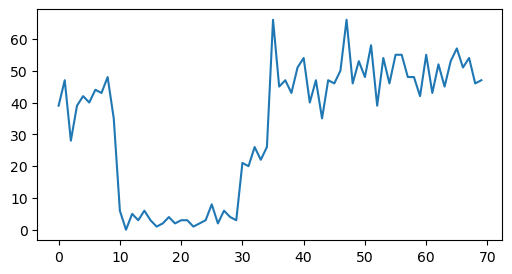

In [2]:
def generate_data():

    true_rates = [40, 3, 20, 50]
    true_durations = [10, 20, 5, 35]

    obs = [
        dist.Poisson(rate).expand([steps]).sample() \
            for rate, steps in zip(true_rates, true_durations)
            ]
    
    states = torch.concatenate(
        [torch.full(i.size(), k) for k, i in enumerate(obs)]
        )

    return states, torch.concatenate(obs)

states, emissions = generate_data()

plt.figure(figsize=(6, 3))
plt.plot(torch.arange(0, len(emissions)), emissions);

In [165]:
transition_probs = torch.tensor(
    [[0.95, 0.01666667, 0.01666667, 0.01666667],
    [0.01666667, 0.95, 0.01666667, 0.01666667],
    [0.01666667, 0.01666667, 0.95, 0.01666667],
    [0.01666667, 0.01666667, 0.01666667, 0.95]])

In [17]:
num_states = 4
num_obs = 10
duration = 70
init_prior = torch.ones((num_states,)) / (num_states * 1.0)

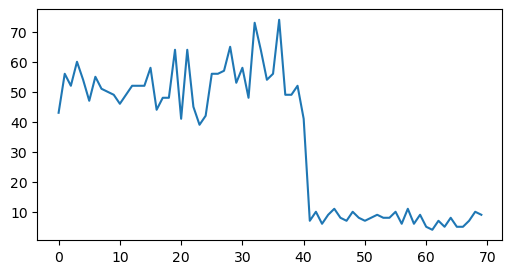

In [168]:
rate_prior = pyro.sample('rate', dist.LogNormal(3., 1.).expand([4]))
emission_probs = dist.Poisson(rate_prior).expand([70, 4])

# batch size of emission_probs indicates: p(y_t | Z = z_k)
hmm = dist.DiscreteHMM(
    initial_logits=init_prior.log(),
    transition_logits=transition_probs.log(),
    observation_dist=emission_probs,
    duration=70
).sample()

plt.figure(figsize=(6, 3))
plt.plot(torch.arange(0, len(states)), hmm);

In [19]:
def model_2(states, output):

    num_states = len(torch.unique(states))

    # prior params. of Poisson rate (lambda)
    emission_prior_loc = 1.
    emission_prior_scale = 1.

    # uniform prior probs. of state Z = z
    init_probs = torch.ones((num_states,)) / (num_states * 1.0)

    # prior dist. of Poisson rate
    rate_prior = pyro.sample('emission_prior', dist.LogNormal(
        loc=emission_prior_loc,
        scale=emission_prior_scale).expand([4])
        )

    transition_probs = torch.tensor(
        [[0.95, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.95, 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.95, 0.01666667],
        [0.01666667, 0.01666667, 0.01666667, 0.95]
        ])
    
    # learn the transition probabilities
    trans_dist = pyro.sample(
        'Aij', dist.Dirichlet(transition_probs)
        )

    #with pyro.plate('sequences', len(states)):

    obs_dist = dist.Poisson(rate_prior).expand([70, 4])

    hmm_dist = dist.DiscreteHMM(
        init_probs.log(),
        trans_dist.log(),
        obs_dist,
        duration=len(states)
        )

    pyro.sample('y', hmm_dist, obs=output)

    return hmm_dist


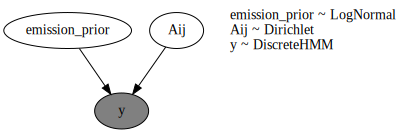

In [20]:
pyro.render_model(model_2, (states, emissions), render_distributions=True)

In [ ]:
nuts_kernel = NUTS(model_2, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=100)
mcmc.run(states, emissions)

In [8]:
mcmc.summary() 


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
emission_prior[0]     32.63     14.53     39.03      2.93     47.97     13.40      1.00
emission_prior[1]      3.18      0.78      3.33      2.49      4.27     22.99      1.07
emission_prior[2]     40.83     17.02     48.06      3.33     51.17      6.54      1.24
emission_prior[3]     18.71      8.05     21.77      1.60     25.50      5.52      1.26

Number of divergences: 0


In [9]:
samples = mcmc.get_samples(1000)
posterior_predictive = Predictive(model_2, samples)(states, None)

In [13]:
posterior_predictive['y'].shape

torch.Size([1000, 70])

In [193]:
state_0 = samples['emission_prior'][:, 0]
state_1 = samples['emission_prior'][:, 1]
state_2 = samples['emission_prior'][:, 2]
state_3 = samples['emission_prior'][:, 3]

In [194]:
state_0.mean(), state_1.mean(), state_2.mean(), state_3.mean()

(tensor(46.7690), tensor(3.9973), tensor(0.0163), tensor(21.0097))

In [86]:
num_states = 4
num_obs = 10
duration = 70

transition_prior = torch.ones((num_states,)) / (num_states * 1.0)
emission_prior = torch.empty(num_obs).fill_(0.1)
transition_probs = dist.Dirichlet(transition_prior).sample(torch.Size([num_states]))
emission_probs = dist.Dirichlet(emission_prior).sample(torch.Size([num_states]))

states, obs = [], []
for i in range(duration):
    if i == 0:
        state = dist.Categorical(transition_prior).sample()
    state = dist.Categorical(transition_probs[state]).sample()
    observation = dist.Categorical(emission_probs[state]).sample()

    states.append(state)
    obs.append(observation)

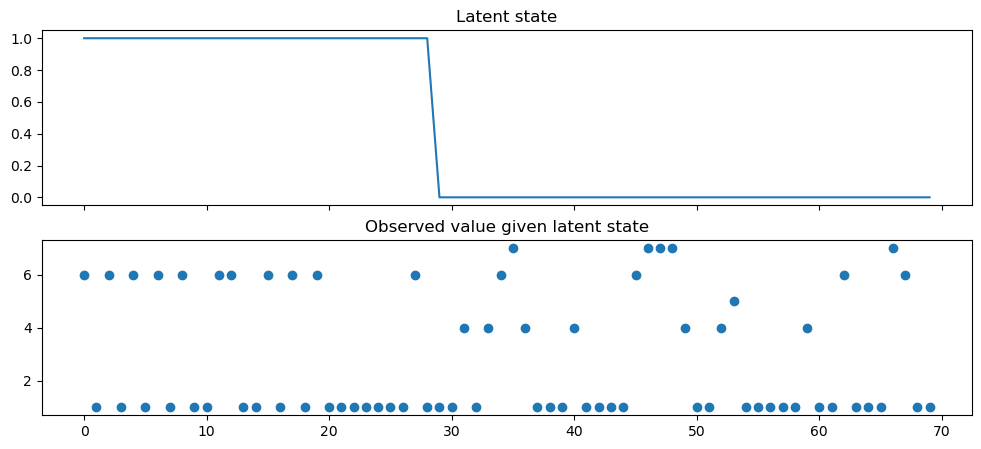

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 5))

ax[0].plot(torch.arange(0, duration), states);
ax[0].set_title('Latent state')
ax[1].scatter(torch.arange(0, duration), obs)
ax[1].set_title('Observed value given latent state');